In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym

from stable_baselines3 import DQN
from stable_baselines3.common import results_plotter
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor




# PPO

## Create Callback

In [ ]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    # def _init_callback(self) -> None:
    #     # Create folder if needed
    #     if self.save_path is not None:
    #         os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

## Plot Functions

In [ ]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    #y = moving_average(y, window=50)
    # Truncate x
    #x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

## Create Gif

In [37]:
import imageio
import numpy as np
from stable_baselines3 import A2C

def create_gif(env, model_path, path, name):
    #model = A2C.load(model_path, env=env)
    model = DQN.load(dir, env=env)
    images = []

    vec_env = model.get_env()
    obs = vec_env.reset()
    img = vec_env.render()
    for i in range(500):
        images.append(img)
        action, _ = model.predict(obs)
        obs, _, _ ,_ = vec_env.step(action)
        img = vec_env.render(mode='rgb_array')
    gif_name =  path + name + '.gif'
    imageio.mimsave(gif_name, [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

## Discrete space

In [16]:
# Create environment
env = gym.make("CarRacing-v2", continuous=False)

In [25]:
#setup callback

# Create log dir
log_dir = "dqn_discrete/"
os.makedirs(log_dir, exist_ok=True)

# Wrap the environment
env = Monitor(env, log_dir)

callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

### Train agent

In [26]:
# Instantiate the agent
model = DQN("MlpPolicy", env, verbose=1, buffer_size=10000)
# Train the agent and display a progress bar
timesteps = 10000
model.learn(total_timesteps=int(timesteps), callback=callback)

Using cpu device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -12.16
Saving new best model to dqn_discrete/best_model.zip
Num timesteps: 2000
Best mean reward: -12.16 - Last mean reward per episode: 23.87
Saving new best model to dqn_discrete/best_model.zip
Num timesteps: 3000
Best mean reward: 23.87 - Last mean reward per episode: 1823.97
Saving new best model to dqn_discrete/best_model.zip
Num timesteps: 4000
Best mean reward: 1823.97 - Last mean reward per episode: 9176.07
Saving new best model to dqn_discrete/best_model.zip
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | -53.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 58       |
|    time_elapsed     | 68       |
|    total_timesteps  | 4000     |
----------

In [27]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=5)

In [28]:
print(mean_reward, std_reward)

-93.0672498 0.4867585365038383


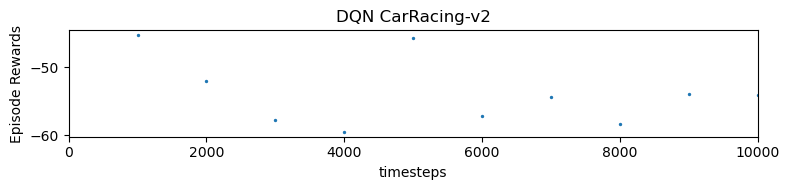

In [29]:
# Helper from the library
results_plotter.plot_results(
    [log_dir], timesteps, results_plotter.X_TIMESTEPS, "DQN CarRacing-v2"
)

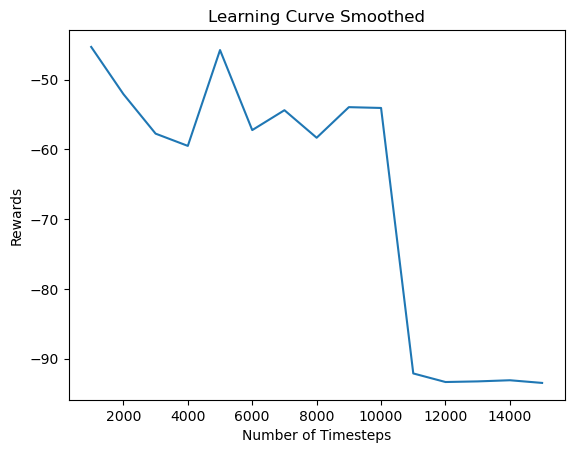

In [30]:
plot_results(log_dir)

### Load pre-trained model

In [31]:
test_env = gym.make("CarRacing-v2", render_mode='human', continuous=False)
dir = os.path.join(log_dir, "best_model.zip")
model = DQN.load(dir, env=test_env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [32]:
vec_env = model.get_env()
obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = vec_env.step(action)
    #obs, rewards, dones, info = test_env.step(action)
    vec_env.render()
    if done:
        break

vec_env.close()

In [38]:
test_env = gym.make("CarRacing-v2", render_mode='rgb_array', continuous=False)
dir = os.path.join(log_dir, "best_model")
create_gif(test_env, dir, log_dir, "dqn_car")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
